# Time series forecasting fundamentals with TensorFlow + Milestone Project 3: BitPredict 💰📈

Let's write some TensorFlow code to predict the price of Bitcoin on the historical price of Bitcoin.

## Get data

We're going to be using the historical price data of Bitcoin to try and predict the future price of bitcoin we download the data from here: https://www.investing.com/crypto/bitcoin/historical-data

## Importing time series with pandas

In [1]:
# Import with pandas
import pandas as pd

# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv('bitcoin.csv', parse_dates=['Date'], index_col=['Date'])

df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2013-10-10,140.4,139.5,141.7,138.5,11.08K,0.65%
2013-10-11,140.1,140.4,141.9,138.9,7.25K,-0.22%
2013-10-12,142.9,140.1,143.1,139.4,11.02K,1.99%
2013-10-13,147.5,142.9,147.6,141.5,16.17K,3.25%
2013-10-14,151.4,147.5,153.7,146.0,29.99K,2.60%


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3975 entries, 2013-10-10 to 2024-08-27
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Price     3975 non-null   object
 1   Open      3975 non-null   object
 2   High      3975 non-null   object
 3   Low       3975 non-null   object
 4   Vol.      3975 non-null   object
 5   Change %  3975 non-null   object
dtypes: object(6)
memory usage: 217.4+ KB


In [3]:
# Transform Price to float64
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3975 entries, 2013-10-10 to 2024-08-27
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Price     3975 non-null   float64
 1   Open      3975 non-null   object 
 2   High      3975 non-null   object 
 3   Low       3975 non-null   object 
 4   Vol.      3975 non-null   object 
 5   Change %  3975 non-null   object 
dtypes: float64(1), object(5)
memory usage: 217.4+ KB


In [4]:
df.head()

,Price,Open,High,Low,Vol.,Change %
Date,,,,,,
2013-10-10,140.4,139.5,141.7,138.5,11.08K,0.65%
2013-10-11,140.1,140.4,141.9,138.9,7.25K,-0.22%
2013-10-12,142.9,140.1,143.1,139.4,11.02K,1.99%
2013-10-13,147.5,142.9,147.6,141.5,16.17K,3.25%
2013-10-14,151.4,147.5,153.7,146.0,29.99K,2.60%


In [5]:
# How many samples do we have?
df.shape

(3975, 6)

Typically deep learning models usually likes lots and lots and lots of samples (where lots and lots can thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.

> 🔑 **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year. 

In [6]:
# Only keep the Price column for each day
bitcoin_prices = df[['Price']]
bitcoin_prices.head()

,Price
Date,
2013-10-10,140.4
2013-10-11,140.1
2013-10-12,142.9
2013-10-13,147.5
2013-10-14,151.4


Text(0.5, 0, 'Date')

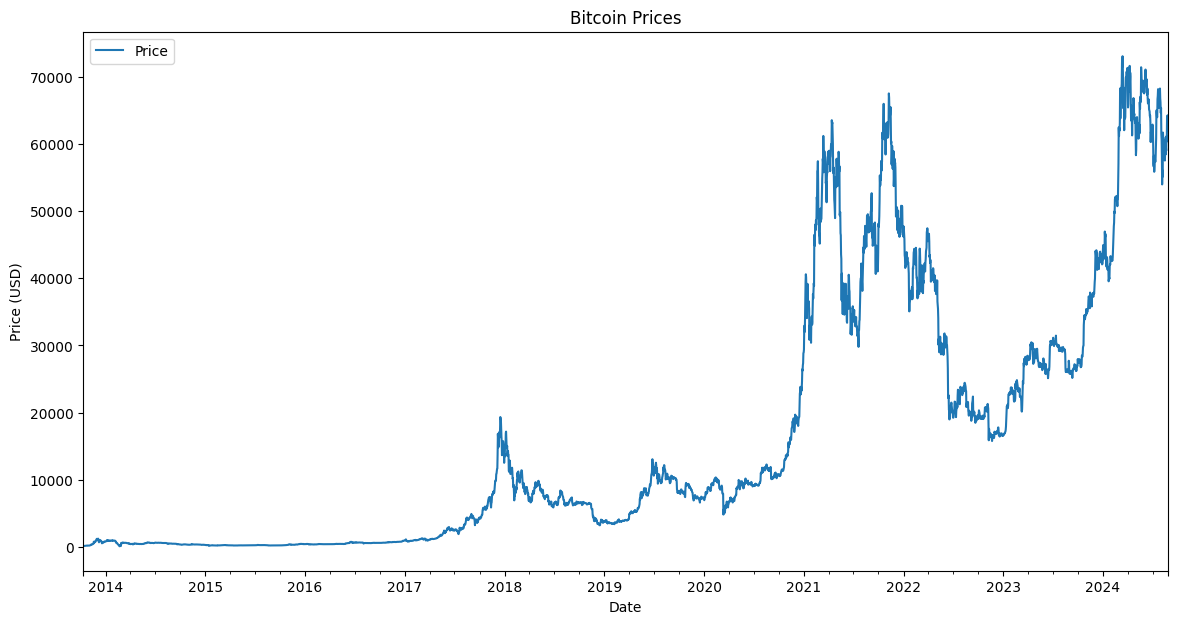

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(14, 7))
plt.title('Bitcoin Prices')
plt.ylabel('Price (USD)')
plt.xlabel('Date')

## Importing time series data with Python CSV module

Text(0.5, 0, 'Date')

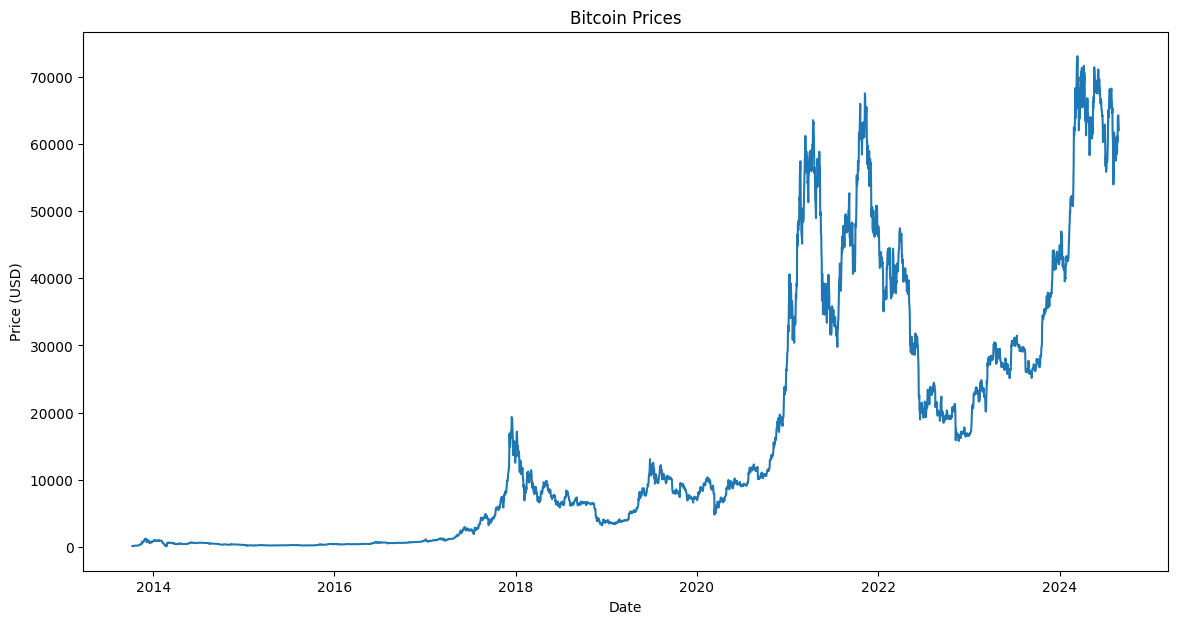

In [8]:
# Importing and formatting the data
import csv
from datetime import datetime

dates = []
prices = []
with open('bitcoin.csv', 'r') as f:
    reader = csv.reader(f)
    next(reader)
    for row in reader:
        date = datetime.strptime(row[0], '%Y-%m-%d')
        price = float(row[1].replace(',', ''))
        dates.append(date)
        prices.append(price)

# Plotting the data
plt.figure(figsize=(14, 7))
plt.plot(dates, prices)
plt.title('Bitcoin Prices')
plt.ylabel('Price (USD)')
plt.xlabel('Date')

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [9]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()

# Get bitcoin price array
prices = bitcoin_prices['Price'].to_numpy()

timesteps[:10], prices[:10]

(array(['2013-10-10T00:00:00.000000000', '2013-10-11T00:00:00.000000000',
        '2013-10-12T00:00:00.000000000', '2013-10-13T00:00:00.000000000',
        '2013-10-14T00:00:00.000000000', '2013-10-15T00:00:00.000000000',
        '2013-10-16T00:00:00.000000000', '2013-10-17T00:00:00.000000000',
        '2013-10-18T00:00:00.000000000', '2013-10-19T00:00:00.000000000'],
       dtype='datetime64[ns]'),
 array([140.4, 140.1, 142.9, 147.5, 151.4, 158.1, 152.8, 157.6, 168.3,
        183.1]))

In [10]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(timesteps, prices, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3180,), (795,), (3180,), (795,))

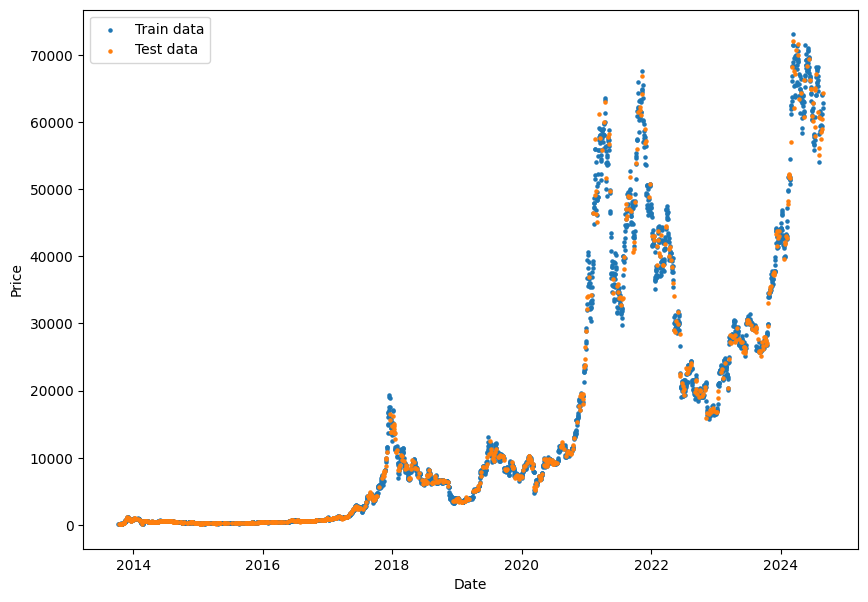

In [11]:
# Let's plot wrong train/test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

### Create train & test sets for time series (the correct way)

In [12]:
# Correct way to make train/test sets for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splits (everything before the split)
X_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything after the split)
X_test, y_test = timesteps[split_size:], prices[split_size:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3180,), (795,), (3180,), (795,))

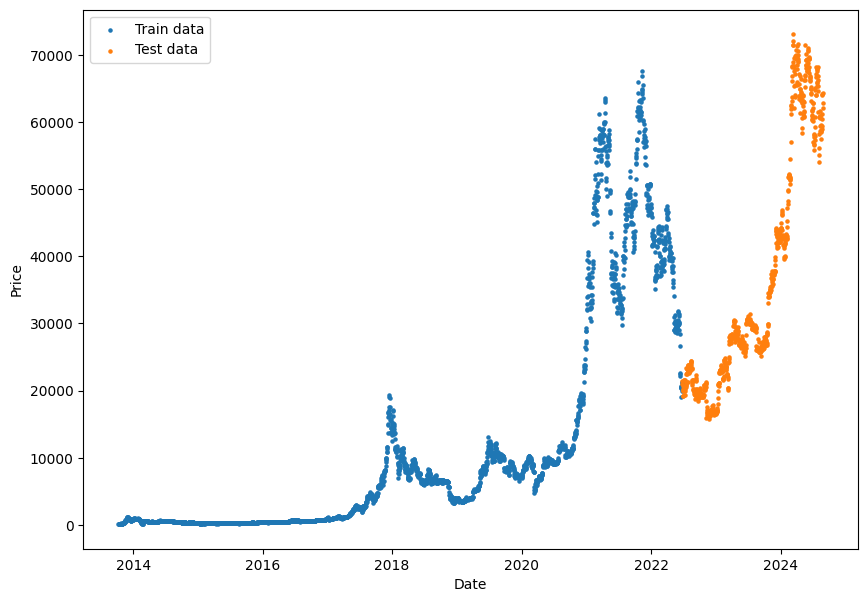

In [13]:
# Plot correct train/test splits
plt.figure(figsize=(10, 7))
plt.scatter(X_train, y_train, s=5, label='Train data')
plt.scatter(X_test, y_test, s=5, label='Test data')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()

## Create a plotting function

In [14]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format='.', start=0, end=None, label=None):
    """
    Plots a timesteps (a series of points in time) against values (a series of values across time).

    Parameters
    ----------
    timesteps : array of timesteps
        Array of timesteps (e.g. actual dates).
    values : array of values
    Array of values across time.
    format : str
        A style format string, e.g. "-" for solid line, "o" for circle.
    start : int
        Where to start the plot (setting a value will index from start of array).
    end : int
        Where to end the plot (setting a value will index from end of array).
    label : str
        A label to show on the plot (useful for making a legend).
    """
    plt.plot(timesteps[start:end], values[start:end], format, label=label)
    plt.xlabel('Time')
    plt.ylabel('Value')
    if label:
        plt.legend(fontsize=14) # make label bigger
    plt.grid(True)

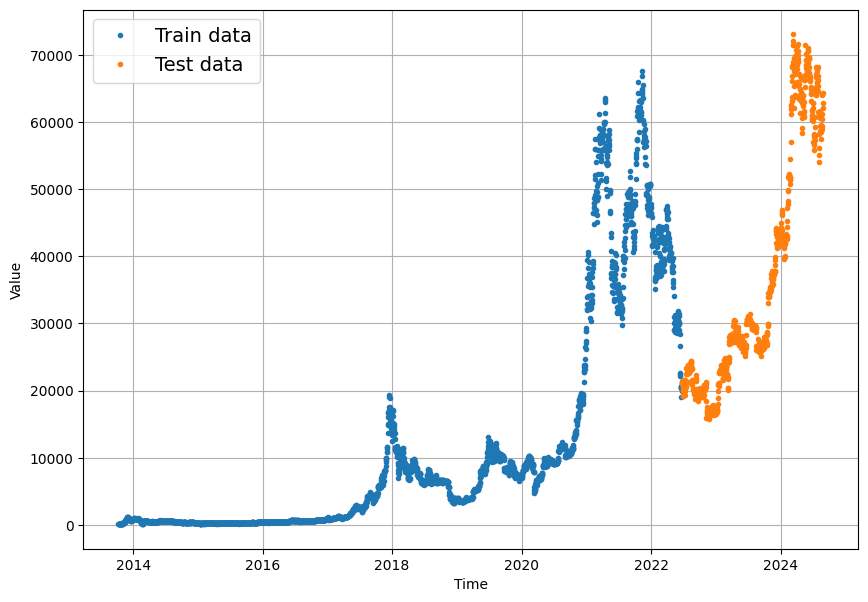

In [15]:
# Testing the function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with: 
* **Horizon** = number of timesteps into the future we're going to predict
* **Window size** = number of timesteps we're going to use to predict **horizon**

Modelling experiments we're running:
* 0 Naive model (baseline)
* 1 Dense model, horizon = 1, window = 7
* 2 Sames as 1, horizon = 1, window = 30
* 3 Sames 1, horizon = 7, window = 30
* 4 Conv1D
* 5 LSTM
* 6 Sames as 1 (but with multivariate data)
* 7 N-BEATs Algorithm 
* 8 Ensemble (multiple models optimized on different loss functions)
* 9 Future prediction model (model to predict future values)
* 10 Same as 1 (but with turkey data introduced)

## Model 0: Naive forecast (baseline)

$$\hat{y}_{t} = y{_{t-1}}$$

> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [16]:
# Create a naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([21489.9, 21043.5, 20730.2, 20278. , 20111.3, 19926.6, 19262.9,
        19243.2, 19309.9, 20215.8]),
 array([59483.1, 58446.3, 59470.9, 59005.8, 61158.1, 60372.2, 64053.1,
        64159.3, 64273.2, 62846.2]))

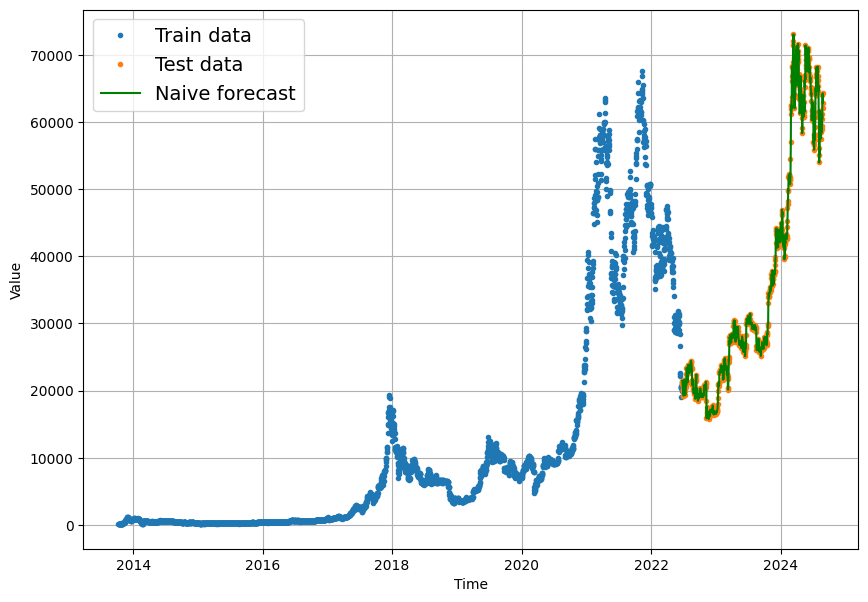

In [17]:
# Plot naive forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_train, values=y_train, label='Train data')
plot_time_series(timesteps=X_test, values=y_test, label='Test data')
plot_time_series(timesteps=X_test[1:], values=naive_forecast, format='g-', label='Naive forecast')

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting.

What are we doing?

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics.

A few common regression metrics (which can also be used for time series forecasting):
* MAE - mean absolute error
* MSE - mean squared error
* RMSE - root mean square error
* MAPE/sMAPE - (symmetric) mean absolute percentage error
* MASE - mean absolute scaled error

For all of the above metrics, **lower is better**, for example, an MAE of 0 is better than an MAE of 100.

The main thing we're evaluating here is: **how do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

In [18]:
import tensorflow as tf
import numpy as np

2024-09-03 10:10:21.615765: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-03 10:10:21.789583: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-03 10:10:21.838277: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-03 10:10:22.251982: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-03 10:10:23.788863: W tensorflow/compiler/tf2

In [19]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
    """
    Implement MASE (assuming no seasonality of data).
    """
    mae = tf.reduce_mean(tf.abs(y_true - y_pred)) # mean absolute error
    
    # Find MAE of naive forecast (no seasonality)
    mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:] - y_true[:-1])) # naive forecast for comparison
    return mae / mae_naive_no_season

In [20]:
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

I0000 00:00:1725369025.246045    1378 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:29:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725369025.666530    1378 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:29:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725369025.666601    1378 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:29:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725369025.672119    1378 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:29:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1725369025.672264    1378 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:29:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:0

0.9995705034091599

In [21]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
    # Ensure the inputs are numpy arrays or compatible tensors
    y_true = np.array(y_true, dtype=np.float32)
    y_pred = np.array(y_pred, dtype=np.float32)

    # Calculate various metrics
    mae = np.mean(np.abs(y_true - y_pred), axis=0)
    mse = np.mean((y_true - y_pred) ** 2, axis=0)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((y_true - y_pred) / y_true), axis=0) * 100
    mase = mean_absolute_scaled_error(y_true, y_pred).numpy()

    # Account for the case of multiple metrics
    if np.ndim(mae) > 0:
        mae = mae.mean()
        mse = mse.mean()
        rmse = rmse.mean()
        mape = mape.mean()
    
    return {'mae': mae,
            'mse': mse,
            'rmse': rmse,
            'mape': mape,
            'mase': mase}

In [22]:
naive_results = evaluate_preds(y_true=y_test[1:], y_pred=naive_forecast)
naive_results

{'mae': 677.11993,
 'mse': 1216993.8,
 'rmse': 1103.1744,
 'mape': 1.7938580363988876,
 'mase': 0.9995706}

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0,1,2,3,4,5,6] -> [7]
[1,2,3,4,5,6,7] -> [8]
[2,3,4,5,6,7,8] -> [9]
```

In [23]:
# What we want to do wit our Bitcoin data
print(f"We want to use: {prices[:7]} to predict {prices[7]}")

We want to use: [140.4 140.1 142.9 147.5 151.4 158.1 152.8] to predict 157.6


In [24]:
# Let's setup global variables for window and horizon size
HORIZON = 1 # predict 1 step at a time
WINDOW_SIZE = 7 # use a week worth of timesteps to predict the horizon

In [25]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
    """
    Creates labels for windowed dataset.

    E.g. if horizon=1 (default)
    Input: [1, 2, 3, 4, 5, 6, 7, 8] -> Output: ([1, 2, 3, 4, 5, 6], [7])
    """
    return x[:, :-horizon], x[:, -horizon:]

In [26]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label: {tf.squeeze(test_label).numpy()}")

Window: [0 1 2 3 4 5 6] -> Label: 7


We've got a way to label our windowed data.

However, this only works on a small scale.

We need a way to do the above across our entire time series.

We could, do this with Python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing - https://numpy.org/doc/stable/user/basics.indexing.html

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example:
```
[[0,1,2,3,4,5,6],
[1,2,3,4,5,6,7],
[2,3,4,5,6,7,8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_windows()` function we created above to turn the window steps into windows with a specified horizon

In [27]:
# Create function to view NumPy arrays as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
    """
    Turns a 1D array into a 2D array of sequential windows of window_size.
    """
    # Create a window of specific window_size (add the horizon on the end for labelling later)
    window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)
    
    # Create a 2D array of multiple window steps (minus 1 to account for 0 indexing)
    window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T # create 2D array of windows of size window_size
    
    # Index on the target array (time series) with 2D array indexes
    windowed_array = x[window_indexes]

    # Get the window and label
    windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
    
    return windows, labels

In [28]:
# Test out the window making function
test_windows, test_labels = make_windows(prices)
# show the first 3 windows/labels
for i in range(3): 
    print(f"Window: {test_windows[i]} -> Label: {test_labels[i]}")

# show the last 3 windows/labels
for i in range(3): 
    print(f"Window: {test_windows[-(i+1)]} -> Label: {test_labels[-(i+1)]}")

Window: [140.4 140.1 142.9 147.5 151.4 158.1 152.8] -> Label: [157.6]
Window: [140.1 142.9 147.5 151.4 158.1 152.8 157.6] -> Label: [168.3]
Window: [142.9 147.5 151.4 158.1 152.8 157.6 168.3] -> Label: [183.1]
Window: [59005.8 61158.1 60372.2 64053.1 64159.3 64273.2 62846.2] -> Label: [62084.1]
Window: [59470.9 59005.8 61158.1 60372.2 64053.1 64159.3 64273.2] -> Label: [62846.2]
Window: [58446.3 59470.9 59005.8 61158.1 60372.2 64053.1 64159.3] -> Label: [64273.2]


> 🔑**Note:** There's a function which does similar to the above in `tf.keras.preprocessing.timeseries_dataset_from_array`, an extension could be to try and replicate what we've done using the premade function: https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/timeseries_dataset_from_array

## Turning windows into training and test sets

In [29]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
    """
    Splits matching pairs of windows and labels into train and test splits.
    """
    split_size = int(len(windows) * (1 - test_split))
    train_windows, test_windows = windows[:split_size], windows[split_size:]
    train_labels, test_labels = labels[:split_size], labels[split_size:]
    return train_windows, test_windows, train_labels, test_labels

In [30]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(windows=test_windows, labels=test_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3174, 794, 3174, 794)

In [31]:
train_windows[:5], train_labels[:5]

(array([[140.4, 140.1, 142.9, 147.5, 151.4, 158.1, 152.8],
        [140.1, 142.9, 147.5, 151.4, 158.1, 152.8, 157.6],
        [142.9, 147.5, 151.4, 158.1, 152.8, 157.6, 168.3],
        [147.5, 151.4, 158.1, 152.8, 157.6, 168.3, 183.1],
        [151.4, 158.1, 152.8, 157.6, 168.3, 183.1, 186.1]]),
 array([[157.6],
        [168.3],
        [183.1],
        [186.1],
        [192.8]]))

## Make a modelling checkpoint

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [32]:
import os

# Create a function to implement a model checkpoint callback with a specific filename
def create_model_checkpoint(model_name, save_path="model_experiments"):
    # Ensure the model name ends with .keras
    model_name_with_extension = f"{model_name}.keras"
    return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name_with_extension), # create filepath to save model
                                              verbose=0, # only output a limited amount of text
                                              save_best_only=True) # save only the best model to file


## Model 1: Dense model (window = 7, horizon = 1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLu
* An output layer with linear activation (no activation)
* Adam optimization and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values?

I picked them out of experimentation.

* **Hyperparameters** = values a machine learning practitioner (you!) can adjust themselves
* **Parameters** = values a model learns on its own

In [33]:
from tensorflow.keras import layers # type: ignore

# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# 1. Construct the model
model_1 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON) # linear activation by default
], name='model_1_dense')

# 2. Compile the model
model_1.compile(loss='mae', # mean absolute error
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', "mse"])

# 3. Fit the model
model_1.fit(x=train_windows, # train windows of 7 days of Bitcoin prices
            y=train_labels, # Bitcoin prices for the 8th day
            epochs=100,
            verbose=1,
            batch_size=128, # number of windows to look at before updating the model's parameters
            validation_data=(test_windows, test_labels), # test data
            callbacks=[create_model_checkpoint(model_name=model_1.name)]) # save only the best model

Epoch 1/100


I0000 00:00:1725369027.147187    1750 service.cc:146] XLA service 0x7f47a40082a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1725369027.147237    1750 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Ti, Compute Capability 8.6
2024-09-03 10:10:27.222805: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-03 10:10:27.482257: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8904


 1/25 ━━━━━━━━━━━━━━━━━━━━ 35s 1s/step - loss: 10506.3115 - mae: 10506.3115 - mse: 363758752.0000

I0000 00:00:1725369027.987571    1750 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 49ms/step - loss: 6048.7925 - mae: 6048.7925 - mse: 146066592.0000 - val_loss: 3802.9609 - val_mae: 3802.9609 - val_mse: 20830668.0000
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 824.6501 - mae: 824.6501 - mse: 3162339.0000 - val_loss: 1096.4618 - val_mae: 1096.4618 - val_mse: 2662730.0000
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 538.1867 - mae: 538.1867 - mse: 1416217.3750 - val_loss: 1026.7911 - val_mae: 1026.7911 - val_mse: 2480332.5000
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 495.4145 - mae: 495.4145 - mse: 1216929.1250 - val_loss: 980.9019 - val_mae: 980.9019 - val_mse: 2282821.7500
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 473.8713 - mae: 473.8713 - mse: 1127282.8750 - val_loss: 921.4619 - val_mae: 921.4619 - val_mse: 2038071.1250
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 454.3806 - mae: 454.3806 - mse: 1045082.8750 - val_loss: 894.0358 - val_mae: 894.0358 - val_mse:

In [34]:
# Evaluate model on the test data
model_1.evaluate(test_windows, test_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 582.7611 - mae: 582.7611 - mse: 736930.3750  


[836.8434448242188, 836.8434448242188, 1571946.25]

In [35]:
# Load in best version of model 1 and evaluate on test data
model_1 = tf.keras.models.load_model('model_experiments/model_1_dense.keras')
model_1.evaluate(test_windows, test_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 481.5664 - mae: 481.5664 - mse: 579132.8750


[680.0896606445312, 680.0896606445312, 1215903.625]

## Making forecasts with a model (on the test dataset)

To make "forecast" on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's write a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions 

In [36]:
def make_preds(model, input_data):
    """
    Uses model to make predictions on input_data.

    Parameters
    ----------
    model: trained model
    input_data: windowed input data (same kind of data model was trained on)

    Returns model predictions on input_data.
    """
    forecast = model.predict(input_data)
    return tf.squeeze(forecast) # return 1D array of predictions

In [37]:
# Make predictions using model_1 on the test dataset and view the results
model_1_preds = make_preds(model_1, test_windows)
model_1_preds[:10]

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([21369.28 , 21214.223, 20804.92 , 20316.303, 20056.44 , 19881.832,
       19312.098, 19194.877, 19260.775, 19977.09 ], dtype=float32)>

In [38]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 680.0896,
 'mse': 1215903.6,
 'rmse': 1102.6802,
 'mape': 1.813879981637001,
 'mase': 1.0039545}

In [39]:
naive_results

{'mae': 677.11993,
 'mse': 1216993.8,
 'rmse': 1103.1744,
 'mape': 1.7938580363988876,
 'mase': 0.9995706}

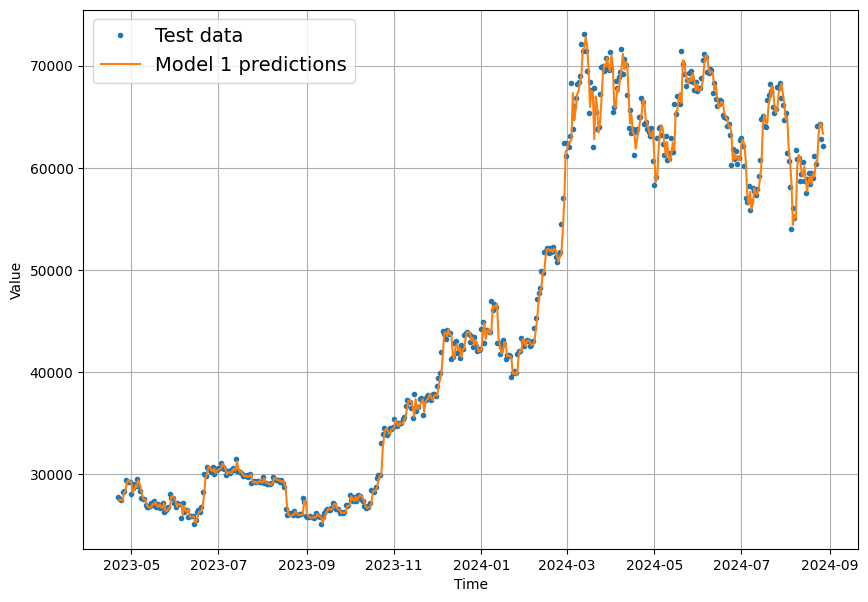

In [40]:
# Let's plot model_1 predictions
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into the test timesteps (timesteps start at 7)
plot_time_series(timesteps=X_test[-len(model_1_preds):], values=test_labels[:, 0], start=offset, label='Test data')

# Plot the model 1 predictions
plot_time_series(timesteps=X_test[-len(model_1_preds):], values=model_1_preds, start=offset, format='-', label='Model 1 predictions')

## Model 2: Dense (window = 30, horizon = 1)

In [41]:
# Make windowed data with window size of 30 (predicting the next day)
HORIZON = 1
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

len(full_windows), len(full_labels)

(3945, 3945)

In [42]:
# Make train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3156, 789, 3156, 789)

In [43]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model_2
model_2 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON) # linear activation by default
], name='model_2_dense')

# Compile model_2
model_2.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# Fit model_2
model_2.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_2.name)])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 8574.5615 - mae: 8574.5615 - mse: 335297152.0000 - val_loss: 2605.2673 - val_mae: 2605.2673 - val_mse: 14202142.0000
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1415.2997 - mae: 1415.2997 - mse: 8869871.0000 - val_loss: 2737.0933 - val_mae: 2737.0933 - val_mse: 14072502.0000
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1002.7166 - mae: 1002.7166 - mse: 4620469.0000 - val_loss: 1641.3922 - val_mae: 1641.3922 - val_mse: 5451376.5000
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 810.3506 - mae: 810.3506 - mse: 3143076.0000 - val_loss: 2041.9424 - val_mae: 2041.9424 - val_mse: 7490939.0000
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 795.8915 - mae: 795.8915 - mse: 3062584.7500 - val_loss: 2156.4368 - val_mae: 2156.4368 - val_mse: 8211808.5000
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 792.7950 - mae: 792.7950 - mse: 3027982.0000 - val_loss: 2305.6860 - val_ma

In [44]:
# Evaluate model_2 on the test data
model_2.evaluate(test_windows, test_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 677.6581 - mae: 677.6581 - mse: 857745.1250  


[943.6902465820312, 943.6902465820312, 1818636.125]

In [45]:
# Load in best version of model 2 and evaluate on test data
model_2 = tf.keras.models.load_model('model_experiments/model_2_dense.keras')
model_2.evaluate(test_windows, test_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 496.2491 - mae: 496.2491 - mse: 603625.1250


[691.7166748046875, 691.7166748046875, 1261302.625]

In [46]:
# Make predictions using model_2 on the test dataset and view the results
model_2_preds = make_preds(model_2, test_windows)
model_2_preds[:10]

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([19380.746, 19523.31 , 19109.613, 19464.496, 19839.764, 20013.604,
       20554.084, 21522.482, 21673.295, 21269.184], dtype=float32)>

In [47]:
# Evaluate preds
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

{'mae': 691.71674,
 'mse': 1261302.4,
 'rmse': 1123.0771,
 'mape': 1.8488803878426552,
 'mase': 1.0180545}

In [48]:
model_1_results

{'mae': 680.0896,
 'mse': 1215903.6,
 'rmse': 1102.6802,
 'mape': 1.813879981637001,
 'mase': 1.0039545}

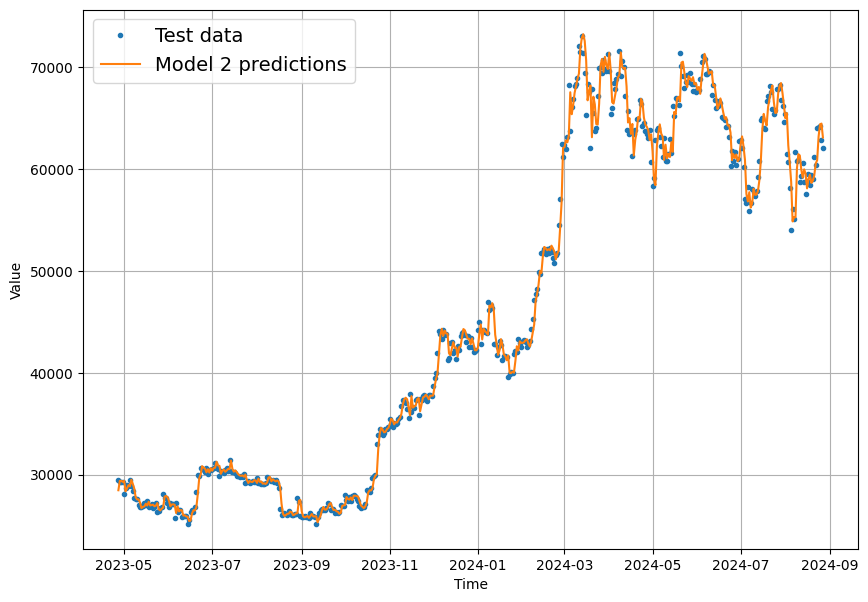

In [49]:
# Plot model_2 predictions
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into the test timesteps (timesteps start at 30)
plot_time_series(timesteps=X_test[-len(model_2_preds):], values=test_labels[:, 0], start=offset, label='Test data')

# Plot the model 2 predictions
plot_time_series(timesteps=X_test[-len(model_2_preds):], values=model_2_preds, start=offset, format='-', label='Model 2 predictions')

## Model 3: Dense (window = 30, horizon = 7)



In [50]:
HORIZON = 7
WINDOW_SIZE = 30

full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(3939, 3939)

In [51]:
# Make train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

len(train_windows), len(test_windows), len(train_labels), len(test_labels)

(3151, 788, 3151, 788)

In [52]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model_3
model_3 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON) # linear activation by default
], name='model_3_dense')

# Compile model_3
model_3.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# Fit model_3
model_3.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_3.name)])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 5s 113ms/step - loss: 7150.5068 - mae: 7150.5068 - mse: 259193424.0000 - val_loss: 4386.3677 - val_mae: 4386.3677 - val_mse: 36717632.0000
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 1499.3267 - mae: 1499.3267 - mse: 10305394.0000 - val_loss: 2733.2107 - val_mae: 2733.2107 - val_mse: 14958684.0000
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1199.9757 - mae: 1199.9757 - mse: 6469607.0000 - val_loss: 2272.4404 - val_mae: 2272.4404 - val_mse: 10964049.0000
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1032.4796 - mae: 1032.4796 - mse: 4985906.5000 - val_loss: 1952.5387 - val_mae: 1952.5387 - val_mse: 8362945.5000
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 942.8640 - mae: 942.8640 - mse: 4256574.0000 - val_loss: 1817.7883 - val_mae: 1817.7883 - val_mse: 7259539.5000
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 897.9618 - mae: 897.9618 - mse: 3959424.7500 - val_loss: 1750.5176 - v

In [53]:
# Evaluate model_3 on the test data
model_3.evaluate(test_windows, test_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 1044.2523 - mae: 1044.2523 - mse: 2396083.0000   


[1429.6246337890625, 1429.6246337890625, 4823971.0]

In [54]:
# Load in best version of model 3 and evaluate on test data
model_3 = tf.keras.models.load_model('model_experiments/model_3_dense.keras')
model_3.evaluate(test_windows, test_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 1039.5282 - mae: 1039.5282 - mse: 2378286.2500 


[1422.3702392578125, 1422.3702392578125, 4794736.0]

In [55]:
# Make predictions using model_3 on the test dataset and view the results
model_3_preds = make_preds(model_3, test_windows)
model_3_preds[:5]

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step


<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[22592.098, 21528.596, 21059.596, 21475.584, 21743.914, 21948.03 ,
        22157.803],
       [21874.066, 21230.125, 21179.227, 21221.77 , 21664.053, 21669.074,
        21351.287],
       [21700.19 , 21164.775, 20499.275, 21227.861, 21256.166, 20717.758,
        21127.852],
       [21262.744, 20382.244, 20800.457, 20318.814, 20643.672, 20048.6  ,
        20731.664],
       [20464.574, 19981.34 , 19538.434, 19827.268, 20072.76 , 20276.902,
        20396.604]], dtype=float32)>

In [56]:
# Evaluate preds
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_3_preds)
model_3_results

{'mae': 1422.3702,
 'mse': 4794736.0,
 'rmse': 2114.8916,
 'mape': 3.8832355,
 'mase': 2.0990896}

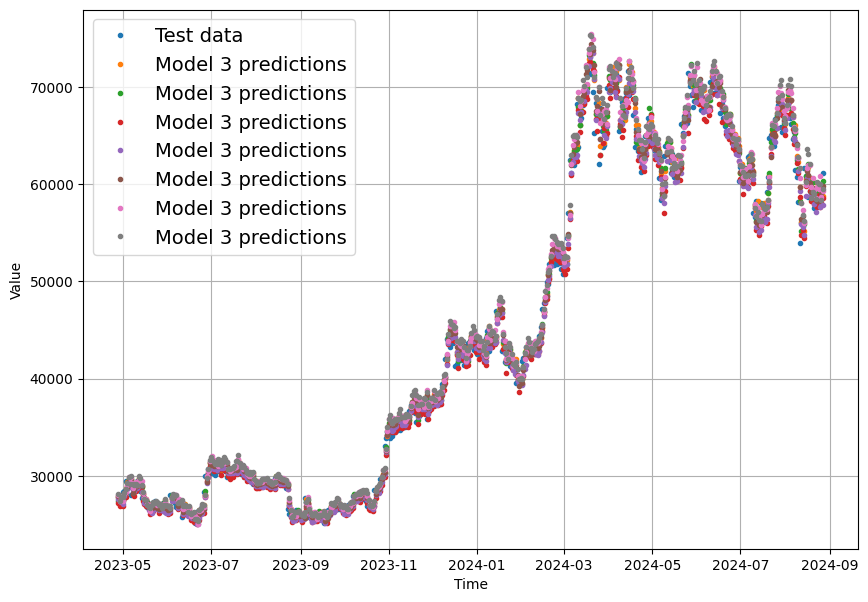

In [57]:
offset = 300
plt.figure(figsize=(10, 7))

# Account for the test_window offset and index into the test timesteps (timesteps start at 30)
plot_time_series(timesteps=X_test[-len(model_3_preds):], values=test_labels[:, 0], start=offset, label='Test data')

# Plot the model 3 predictions
plot_time_series(timesteps=X_test[-len(model_3_preds):], values=model_3_preds, start=offset, label='Model 3 predictions')

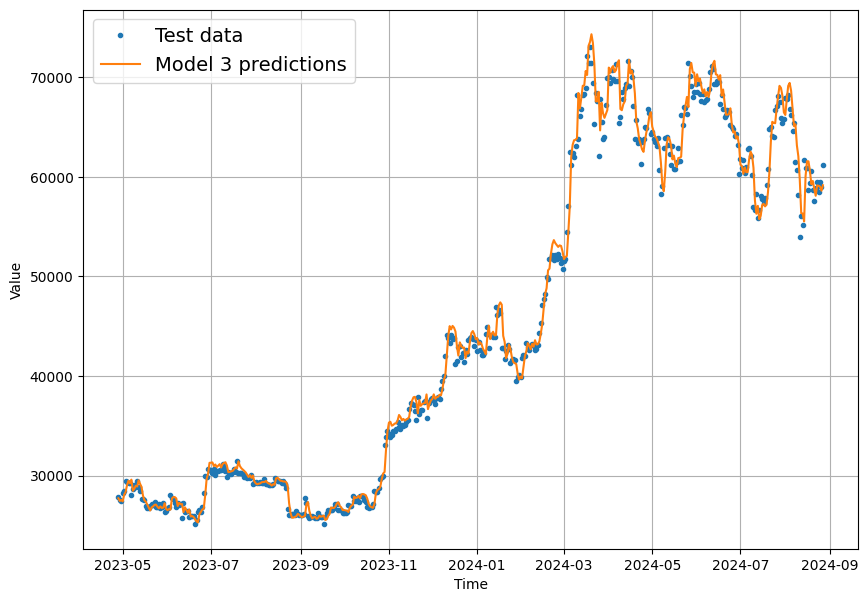

In [58]:
offset = 300
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=X_test[-len(model_3_preds):], values=test_labels[:, 0], start=offset, label='Test data')
plot_time_series(timesteps=X_test[-len(model_3_preds):], values=tf.reduce_mean(model_3_preds, axis=1), format="-", start=offset, label='Model 3 predictions')

## Which of our models is performing the best so far?

So we've trained a few models, now let's compare them and see how they've gone so far

<Axes: >

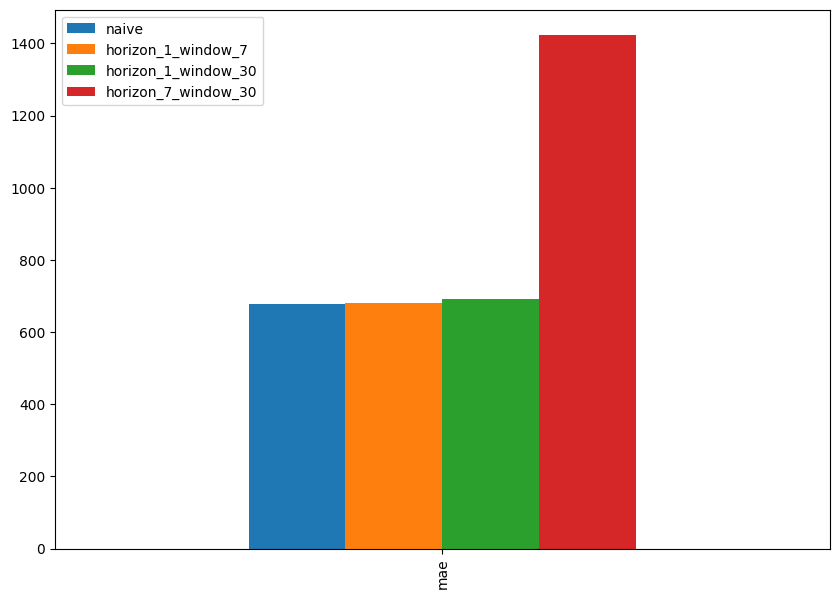

In [59]:
pd.DataFrame({"naive": naive_results["mae"],
              "horizon_1_window_7": model_1_results["mae"],
              "horizon_1_window_30": model_2_results["mae"],
              "horizon_7_window_30": model_3_results["mae"]}, index=["mae"]).plot(figsize=(10, 7), kind='bar')

**🔑Note:** You might be wondering, why are the naive results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at t+1 (the next timestep) is typically close to value at t (the current timestep). In other words, today's value is probably pretty close to yesterday's value. Of course, this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naive model wil often get fairly good results.

**📖Resource:** For more on how autocorrelation influences a model's predictions, see the article https://towardsdatascience.com/how-not-to-use-machine-learning-for-time-series-forecasting-avoiding-the-pitfalls-19f9d7adf424

## Model 4: Conv1D


In [60]:
HORIZON = 1
WINDOW_SIZE = 7

# Create windowed dataset
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)

In [61]:
# Make train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

To use the Conv1D layer, we need an input shape of: `(batch_size, timesteps, input_dim)`

However our data isn't in that shape yet...

In [62]:
# Before we pass our data to the Conv1D layer, we need to make sure it's the right shape
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=array([140.4, 140.1, 142.9, 147.5, 151.4, 158.1, 152.8])>

In [63]:
# Register the custom layer with the Keras Functional API
@tf.keras.utils.register_keras_serializable()
def expand_dims(x):
    return tf.expand_dims(x, axis=1)

expand_dims_layer = layers.Lambda(expand_dims) # add an extra dimension for the Conv1D layer

In [64]:
# Test out the expand_dims_layer
print(f"Original shape: {x.shape}") # (7,)
print(f"Expanded shape: {expand_dims_layer(x).shape}") # (7, 1)
print(f"Original values with expanded shape:\n {expand_dims_layer(x)}\n")

Original shape: (7,)
Expanded shape: (7, 1)
Original values with expanded shape:
 [[140.4]
 [140.1]
 [142.9]
 [147.5]
 [151.4]
 [158.1]
 [152.8]]



In [65]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct the model
model_4 = tf.keras.Sequential([
    # Add an extra dimension to input data (for Conv1D)
    expand_dims_layer,
    layers.Conv1D(filters=128, kernel_size=7, strides=1, padding='causal', activation='relu'),
    # layers.GlobalMaxPool1D(),
    layers.Dense(HORIZON)
], name='model_4_conv1d')

# Compile the model
model_4.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# Fit the model
model_4.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - loss: 7213.2778 - mae: 7213.2778 - mse: 199814704.0000 - val_loss: 4426.4570 - val_mae: 4426.4570 - val_mse: 27716010.0000
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 933.7474 - mae: 933.7474 - mse: 3986487.0000 - val_loss: 1305.7390 - val_mae: 1305.7390 - val_mse: 3622033.0000
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 595.8079 - mae: 595.8079 - mse: 1715615.8750 - val_loss: 1177.5295 - val_mae: 1177.5295 - val_mse: 3228195.2500
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 566.5004 - mae: 566.5004 - mse: 1592559.6250 - val_loss: 1154.4867 - val_mae: 1154.4867 - val_mse: 3108329.0000
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 556.4467 - mae: 556.4467 - mse: 1535706.5000 - val_loss: 1126.9342 - val_mae: 1126.9342 - val_mse: 2948324.0000
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 544.3505 - mae: 544.3505 - mse: 1472037.7500 - val_loss: 1102.7977 - val_mae: 11

In [66]:
# Model summary
model_4.summary()

Model: "model_4_conv1d"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lambda (Lambda)                 │ (None, 1, 7)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 1, 128)         │         6,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1, 1)           │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,589 (76.52 KB)

 Trainable params: 6,529 (25.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 13,060 (51.02 KB)

In [67]:
# Evaluate model_4 on the test data
model_4.evaluate(test_windows, test_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 506.5651 - mae: 506.5651 - mse: 625799.9375   


[728.73779296875, 728.73779296875, 1336409.0]

In [68]:
# Load in best version of model 4 and evaluate on test data
model_4 = tf.keras.models.load_model('model_experiments/model_4_conv1d.keras')
model_4.evaluate(test_windows, test_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 480.7509 - mae: 480.7509 - mse: 577405.4375


[679.0625, 679.0625, 1223265.5]

In [69]:
# Make predictions using model_4 on the test dataset and view the results
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([21480.34 , 21139.738, 20794.465, 20338.488, 20077.773, 19876.52 ,
       19289.   , 19173.852, 19202.145, 20007.564], dtype=float32)>

In [70]:
# Evaluate preds
model_4_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_4_preds)

model_4_results

{'mae': 679.0625,
 'mse': 1223265.4,
 'rmse': 1106.0133,
 'mape': 1.8100110813975334,
 'mase': 1.0024383}

In [71]:
model_1_results

{'mae': 680.0896,
 'mse': 1215903.6,
 'rmse': 1102.6802,
 'mape': 1.813879981637001,
 'mase': 1.0039545}

## Model 5: LSTM

In [72]:
tf.random.set_seed(42)

# Construct model_5
inputs = layers.Input(shape=(WINDOW_SIZE,))
x = expand_dims_layer(inputs)
x = layers.LSTM(128, activation="relu")(x)
output = layers.Dense(HORIZON)(x)
model_5 = tf.keras.Model(inputs=inputs, outputs=output, name='model_5_lstm')

# Compile model_5
model_5.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# Fit model_5
model_5.fit(train_windows,
            train_labels,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(test_windows, test_labels),
            callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 8s 192ms/step - loss: 9547.4951 - mae: 9547.4951 - mse: 298162464.0000 - val_loss: 16049.6299 - val_mae: 16049.6299 - val_mse: 319700320.0000
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3177.2639 - mae: 3177.2639 - mse: 40536468.0000 - val_loss: 2691.7324 - val_mae: 2691.7324 - val_mse: 11172947.0000
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 678.4301 - mae: 678.4301 - mse: 2266394.5000 - val_loss: 1119.0688 - val_mae: 1119.0688 - val_mse: 2788250.0000
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 565.3990 - mae: 565.3990 - mse: 1608234.7500 - val_loss: 1184.0427 - val_mae: 1184.0427 - val_mse: 3186636.7500
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 568.7706 - mae: 568.7706 - mse: 1619796.1250 - val_loss: 1168.2517 - val_mae: 1168.2517 - val_mse: 3151448.7500
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 563.2134 - mae: 563.2134 - mse: 1590788.2500 - val_loss: 1158.0773 - val

In [73]:
# Evaluate model_5 on the test data
model_5.evaluate(test_windows, test_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - loss: 492.1325 - mae: 492.1325 - mse: 598984.0000   


[687.8753051757812, 687.8753051757812, 1254030.0]

In [74]:
# Load in best version of model 5 and evaluate on test data
model_5 = tf.keras.models.load_model('model_experiments/model_5_lstm.keras')
model_5.evaluate(test_windows, test_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 492.1325 - mae: 492.1325 - mse: 598984.0000 


[687.8753051757812, 687.8753051757812, 1254030.0]

In [75]:
# Make predictions using model_5 on the test dataset and view the results
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:10]

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([21441.37 , 21166.22 , 20787.227, 20389.908, 20084.967, 19895.22 ,
       19339.99 , 19139.94 , 19191.791, 19916.3  ], dtype=float32)>

In [76]:
# Evaluate preds
model_5_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_5_preds)
model_5_results

{'mae': 687.8753,
 'mse': 1254029.9,
 'rmse': 1119.8347,
 'mape': 1.8441203981637955,
 'mase': 1.0154477}

**🔑Note:** Because neural network are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results.

## Make a multivariate time series dataset

Before we add a feature to our time series, what is a feature we can use?

One feature we could add is whether or not Elon Musk tweeted on that day...

* day 1 - 0
* day 2 - 1
* day 3 - 0

How about halving events?

https://stormgain.com/blog/bitcoin-halving-dates-history#nav_head_3

In [77]:
bitcoin_prices.tail()

,Price
Date,
2024-08-23,64053.1
2024-08-24,64159.3
2024-08-25,64273.2
2024-08-26,62846.2
2024-08-27,62084.1


In [78]:
# Let's add the bitcoin halving events to our dataset
block_reward_1 = 50 # 3 January 2009 
block_reward_2 = 25 # 28 November 2012
block_reward_3 = 12.5 # 9 July 2016
block_reward_4 = 6.25 # 11 May 2020
block_reward_5 = 3.125 # 19 April 2024

# Dates of Bitcoin halving events
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-11")
block_reward_5_datetime = np.datetime64("2024-04-19")

In [79]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_4_days = (block_reward_5_datetime - bitcoin_prices.index[0]).days

block_reward_2_days, block_reward_3_days, block_reward_4_days

(1003, 2405, 3844)

In [80]:
# Add block reward columns to the DataFrame
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block['block_reward'] = None

# Add in the block reward values as features
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:block_reward_4_days, -1] = block_reward_4
bitcoin_prices_block.iloc[block_reward_4_days:, -1] = block_reward_5

In [81]:
bitcoin_prices_block.head()

,Price,block_reward
Date,,
2013-10-10,140.4,25
2013-10-11,140.1,25
2013-10-12,142.9,25
2013-10-13,147.5,25
2013-10-14,151.4,25


<Axes: xlabel='Date'>

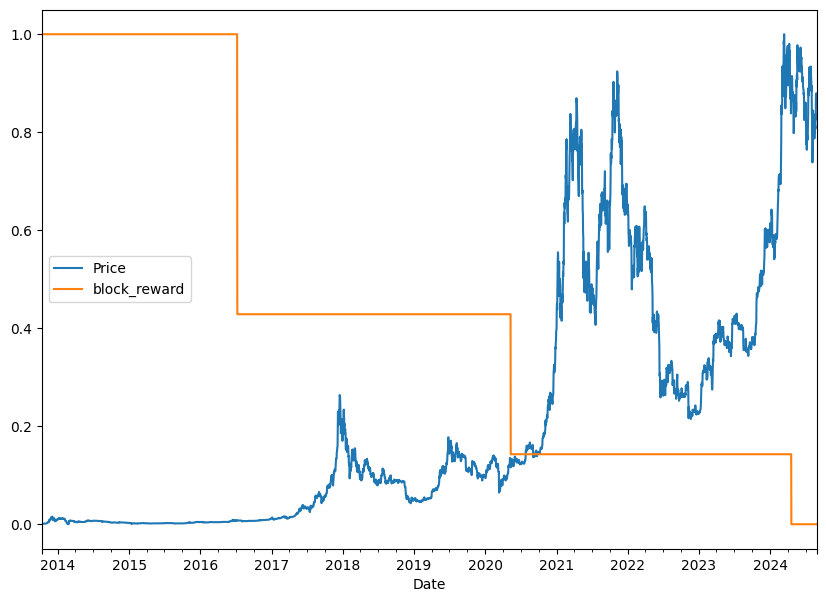

In [82]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[['Price', 'block_reward']]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)

scaled_price_block_df.plot(figsize=(10, 7))

## Making a windowed dataset with Pandas

Previously, we've turned our univariate time series into windowed dataset using the helper functions above.

However, since we've got multivariate data, these functions won't work.

Not to worry, we can use the `pandas.DataFrame.shift()` method to window our multivariate data

In [83]:
# Setup dataset hyperparameters
HORIZON = 1
WINDOW_SIZE = 7

In [84]:
# Make a copy of the Bitcoin historical data with block reward
bitcoin_prices_windowed = bitcoin_prices_block.copy()

# Add windowed columns
for i in range(WINDOW_SIZE):
    bitcoin_prices_windowed[f"Price+{i+1}"] = bitcoin_prices_windowed['Price'].shift(periods=i+1)

bitcoin_prices_windowed.head(10)

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2013-10-10,140.4,25,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-11,140.1,25,140.4,NaN,NaN,NaN,NaN,NaN,NaN
2013-10-12,142.9,25,140.1,140.4,NaN,NaN,NaN,NaN,NaN
2013-10-13,147.5,25,142.9,140.1,140.4,NaN,NaN,NaN,NaN
2013-10-14,151.4,25,147.5,142.9,140.1,140.4,NaN,NaN,NaN
2013-10-15,158.1,25,151.4,147.5,142.9,140.1,140.4,NaN,NaN
2013-10-16,152.8,25,158.1,151.4,147.5,142.9,140.1,140.4,NaN
2013-10-17,157.6,25,152.8,158.1,151.4,147.5,142.9,140.1,140.4
2013-10-18,168.3,25,157.6,152.8,158.1,151.4,147.5,142.9,140.1


What we've done is created a way to window our dataset directly from a pandas dataframe.

```
[0, 1, 2, 3, 4, 5, 6, block_reward] -> [7]
[1, 2, 3, 4, 5, 6, 7, block_reward] -> [8]
[2, 3, 4, 5, 6, 7, 8, block_reward] -> [9]
```

In [85]:
# Create X (windows of prices) and y (next day prices) features
X = bitcoin_prices_windowed.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

In [86]:
X.head()

,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-17,25.0,152.800003,158.100006,151.399994,147.500000,142.899994,140.100006,140.399994
2013-10-18,25.0,157.600006,152.800003,158.100006,151.399994,147.500000,142.899994,140.100006
2013-10-19,25.0,168.300003,157.600006,152.800003,158.100006,151.399994,147.500000,142.899994
2013-10-20,25.0,183.100006,168.300003,157.600006,152.800003,158.100006,151.399994,147.500000
2013-10-21,25.0,186.100006,183.100006,168.300003,157.600006,152.800003,158.100006,151.399994


In [87]:
y.head()

Date
2013-10-17    157.600006
2013-10-18    168.300003
2013-10-19    183.100006
2013-10-20    186.100006
2013-10-21    192.800003
Name: Price, dtype: float32

In [88]:
# Make train and test sets using indexing
split_size = int(0.8 * len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

## Model 6: Dense (multivariate time series)

In [89]:
tf.random.set_seed(42)

# Construct model_6
model_6 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_6_dense_multivariate')

# Compile model_6
model_6.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# Fit model_6
model_6.fit(X_train,
            y_train,
            epochs=100,
            verbose=1,
            batch_size=128,
            validation_data=(X_test, y_test),
            callbacks=[create_model_checkpoint(model_name=model_6.name)])

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 9825.5303 - mae: 9825.5303 - mse: 369920896.0000 - val_loss: 5813.6094 - val_mae: 5813.6094 - val_mse: 45778992.0000
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1187.7565 - mae: 1187.7565 - mse: 6214135.0000 - val_loss: 1283.4418 - val_mae: 1283.4418 - val_mse: 3444714.5000
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 568.3757 - mae: 568.3757 - mse: 1565423.1250 - val_loss: 1022.3539 - val_mae: 1022.3539 - val_mse: 2428712.0000
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 499.1881 - mae: 499.1881 - mse: 1228238.6250 - val_loss: 978.7128 - val_mae: 978.7128 - val_mse: 2302773.2500
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 482.3851 - mae: 482.3851 - mse: 1160754.3750 - val_loss: 966.3038 - val_mae: 966.3038 - val_mse: 2233567.5000
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 467.5367 - mae: 467.5367 - mse: 1097631.7500 - val_loss: 1022.3820 - val_mae: 1022

In [90]:
# Evaluate model_6 on the test data
model_6.evaluate(X_test, y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 666.4606 - mae: 666.4606 - mse: 879780.6875  


[957.2212524414062, 957.2212524414062, 1881964.0]

In [91]:
# Load in best version of model 6 and evaluate on test data
model_6 = tf.keras.models.load_model('model_experiments/model_6_dense_multivariate.keras')
model_6.evaluate(X_test, y_test)

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 476.4838 - mae: 476.4838 - mse: 568475.0625


[677.2393798828125, 677.2393798828125, 1213891.25]

In [92]:
# Make predictions using model_6 on the test dataset and view the results
model_6_preds = make_preds(model_6, X_test)
model_6_preds[:10]

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([21556.1  , 21052.094, 20810.113, 20286.678, 20103.39 , 19888.701,
       19323.455, 19165.652, 19240.537, 20089.441], dtype=float32)>

In [93]:
# Evaluate preds
model_6_results = evaluate_preds(y_true=y_test, y_pred=model_6_preds)
model_6_results

{'mae': 677.2394,
 'mse': 1213891.4,
 'rmse': 1101.7673,
 'mape': 1.8044877797365189,
 'mase': 0.999747}

In [94]:
model_1_results

{'mae': 680.0896,
 'mse': 1215903.6,
 'rmse': 1102.6802,
 'mape': 1.813879981637001,
 'mase': 1.0039545}

## Model 7: N-BEATS algorithm

Let's now try build the biggest baddest (though maybe not the baddest, as in, it perform really well...) time series forecasting model we've built so far.

More specifically, we're going to be replicating the algorithm in the following paper:https://arxiv.org/abs/1905.10437

Why?
* This will alow is to practice replicating a paper with TensorFlow code
* We will se how to use TensorFlow layer subclassing (to make our own custom layers)
* Get experience using the Functional API to create a custom architecture.
* Potentially get state of the art results on our problem

### Building and testing the N-BEATS block layer

Because the N-BEATS block layer doesn't exist in TensorFlow, we've got to create it.

To create custom layer and models in TensorFlow we can use subclassing: https://www.tensorflow.org/guide/keras/making_new_layers_and_models_via_subclassing

In [95]:
# Create NBeatBlock custom layer
class NBeatsBlock(tf.keras.layers.Layer):
    def __init__(
        self,
        input_size: int,
        theta_size: int,
        horizon: int,
        n_neurons: int = 256,
        n_layers: int = 4,
        **kwargs # the **kwargs argument takes care of all the arguments for the parent class super(NBeatsBlock, self).__init__(**kwargs)
    ):  
        super().__init__(**kwargs)
        self.input_size = input_size
        self.theta_size = theta_size
        self.horizon = horizon
        self.n_neurons = n_neurons
        self.n_layers = n_layers

        # Setup block layers
        self.hidden = [
            tf.keras.layers.Dense(n_neurons, activation="relu") for _ in range(n_layers)
        ]
        self.theta_layer = tf.keras.layers.Dense(
            theta_size, activation="linear", name="theta"
        )
        """ self.backcast_layer = tf.keras.layers.Dense(
            input_size, activation="linear", name="backcast"
        ) """

    def call(self, inputs):
        x = inputs
        for layer in self.hidden:
            x = layer(x)
        theta = self.theta_layer(x)
        # output the backcast and the forecast from theta
        backcast, forecast = theta[:, : self.input_size], theta[:, -self.horizon :]
        return backcast, forecast

In [96]:
# Set up dummy NBeatsBlock layer to represents inputs and outputs
dummy_nbeats_block_layer = NBeatsBlock(
    input_size=WINDOW_SIZE,
    theta_size=WINDOW_SIZE + HORIZON,
    horizon=HORIZON,
    n_neurons=128,
    n_layers=4,
)

In [97]:
# Create dummy input data
dummy_inputs = tf.expand_dims(tf.range(WINDOW_SIZE) + 1, axis=0) # input shape (1, WINDOW_SIZE)
dummy_inputs

<tf.Tensor: shape=(1, 7), dtype=int32, numpy=array([[1, 2, 3, 4, 5, 6, 7]], dtype=int32)>

In [98]:
# Pass dummy input data to dummy NBeatsBlock layer
dummy_backcast, dummy_forecast = dummy_nbeats_block_layer(dummy_inputs)
# These are the activation outputs of the theta layer (they'll be random due to no training of the model)
print(f"Dummy backcast: {tf.squeeze(dummy_backcast)}\n")
print(f"Dummy forecast: {tf.squeeze(dummy_forecast)}")

Dummy backcast: [ 0.02771899  0.09700882 -0.65301543 -0.6771829  -0.8318774   0.6331171
 -0.3039927 ]

Dummy forecast: 0.8655542135238647


### Preparing data for the N-BEATS algorithm using `tf.data`

To make our input data load as fast as possible we're going to be adhering to the performant data pipeline steps in the tf.data guide: https://www.tensorflow.org/guide/data

In [99]:
HORIZON = 1
WINDOW_SIZE = 7

In [100]:
# Create N-BEATS data inputs (N-BEATS works with univariate time series data)
bitcoin_prices_nbeats = bitcoin_prices.copy()

In [101]:
# Add windowed columns
for i in range(WINDOW_SIZE):
    bitcoin_prices_nbeats[f"Price+{i+1}"] = bitcoin_prices_nbeats['Price'].shift(periods=i+1)

bitcoin_prices_nbeats.dropna().head(10)

,Price,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,
2013-10-17,157.6,152.8,158.1,151.4,147.5,142.9,140.1,140.4
2013-10-18,168.3,157.6,152.8,158.1,151.4,147.5,142.9,140.1
2013-10-19,183.1,168.3,157.6,152.8,158.1,151.4,147.5,142.9
2013-10-20,186.1,183.1,168.3,157.6,152.8,158.1,151.4,147.5
2013-10-21,192.8,186.1,183.1,168.3,157.6,152.8,158.1,151.4
2013-10-22,203.0,192.8,186.1,183.1,168.3,157.6,152.8,158.1
2013-10-23,228.0,203.0,192.8,186.1,183.1,168.3,157.6,152.8
2013-10-24,207.0,228.0,203.0,192.8,186.1,183.1,168.3,157.6
2013-10-25,197.9,207.0,228.0,203.0,192.8,186.1,183.1,168.3


In [102]:
# Create X and y features
X = bitcoin_prices_nbeats.dropna().drop('Price', axis=1).astype(np.float32)
y = bitcoin_prices_nbeats.dropna()['Price'].astype(np.float32)

# Make train and test sets
split_size = int(0.8 * len(X))
X_train, y_train = X[:split_size], y[:split_size]
X_test, y_test = X[split_size:], y[split_size:]

X_train.head()

,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,
2013-10-17,152.800003,158.100006,151.399994,147.500000,142.899994,140.100006,140.399994
2013-10-18,157.600006,152.800003,158.100006,151.399994,147.500000,142.899994,140.100006
2013-10-19,168.300003,157.600006,152.800003,158.100006,151.399994,147.500000,142.899994
2013-10-20,183.100006,168.300003,157.600006,152.800003,158.100006,151.399994,147.500000
2013-10-21,186.100006,183.100006,168.300003,157.600006,152.800003,158.100006,151.399994


In [103]:
# Time to make our dataset performant using tf.data API
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(1024).prefetch(tf.data.AUTOTUNE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(1024).prefetch(tf.data.AUTOTUNE)

train_dataset, test_dataset

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>)

### Setting up hyperparameters for N-BEATS algorithm

In [104]:
# Values from N-BEATS paper
N_EPOCHS = 5000
N_NEURONS = 512
N_LAYERS = 4
N_STACKS = 30
INPUT_SIZE = WINDOW_SIZE * HORIZON
THETA_SIZE = INPUT_SIZE + HORIZON

### Getting ready for our residual connection

Before we can craft our N-BEATS model, we need two layers for the residual connections (subtract and add).

The N-BEATS algorithm uses double residual stacking to help train its deeper architecture

In [105]:
# Make tensors
tensor_1 = tf.range(10) + 10
tensor_2 = tf.range(10)

# Subtract
subtracted = layers.subtract([tensor_1, tensor_2])

# Add
added = layers.add([tensor_1, tensor_2])

# Get outputs
print(f"Input tensors: {tensor_1.numpy()} and {tensor_2.numpy()}")
print(f"Subtracted: {subtracted.numpy()}")
print(f"Added: {added.numpy()}")

Input tensors: [10 11 12 13 14 15 16 17 18 19] and [0 1 2 3 4 5 6 7 8 9]
Subtracted: [10 10 10 10 10 10 10 10 10 10]
Added: [10 12 14 16 18 20 22 24 26 28]


### Building, compiling and fitting the N-BEATS algorithm

1. Setup an instance of the N-BEATS block layer using `NBeatsBlock` (this'll be the initial block used for the network, the rest will be created as part of stacks)
2. Create an input layer for the N-BEATS stack (we'll be using the Keras Functional API)
3. Make the initial backcast and forecast for the model with the layer created in (1)
4. Use for loop to create stacks of block layers
5. Use the `NBeatsBlock` class within the for loop in (4) to create blocks which return backcast and block-level forecast
6. Create the double residual stacking using subtract and add layer
7. Put the model inputs and outputs together using `tf.keras.Model()`
8. Compile the model with MAE loss (the paper uses multiple losses but we'll use MAE to keep it inline with our other models) and Adam optimizer with default setting
9. Fit the N-BEATS model for 5000 epochs and since it's fitting for so many epochs, we'll use a couple of callbacks:
    * Early Stopping - because the model will be training for so long, we'll stop it early if it stops improving
    * Reduce LR on Plateau (Learning Rate) - if a model stops improving, try lowering the learning to reduce the amount it updates its weights each time (take smaller step towards best performance)

In [106]:
tf.random.set_seed(42)

# 1. Setup and instance of NBeatsBlock
nbeats_block_layer = NBeatsBlock(
    input_size=INPUT_SIZE,
    theta_size=THETA_SIZE,
    horizon=HORIZON,
    n_neurons=N_NEURONS,
    n_layers=N_LAYERS,
    name="initial_block",
)

# 2. Create input to stack
stack_input = layers.Input(shape=(INPUT_SIZE,), name="stack_input")

# 3. Create initial backcast and forecast input (backcast prediction + horizon prediction)
residual, forecast = nbeats_block_layer(stack_input)

# 4. Create stack of blocks layers
for i, _ in enumerate(range(N_STACKS - 1)):

    # 5. Use the NBeatsBlock to calculate the backcast and forecast
    backcast, block_forecast = NBeatsBlock(
        input_size=INPUT_SIZE,
        theta_size=THETA_SIZE,
        horizon=HORIZON,
        n_neurons=N_NEURONS,
        n_layers=N_LAYERS,
        name=f"nbeats_block_layer_{i}"
    )(residual)

    # 6. Create the double residual stacking
    residual = layers.subtract([residual, backcast], name=f"subtract_{i}")
    forecast = layers.add([forecast, block_forecast], name=f"add_{i}")

# 7. Put the stack model together
stack_model = tf.keras.Model(inputs=stack_input, outputs=forecast, name="nbeats_stack_model")

# 8. Compile the model
stack_model.compile(loss='mae',
                    optimizer=tf.keras.optimizers.Adam(),
                    metrics=['mae', 'mse'])

# 9. Fit the model with EarlyStopping and ReduceLROnPlateau callbacks
stack_model.fit(train_dataset,
                epochs=N_EPOCHS,
                validation_data=test_dataset,
                callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True),
                           tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=100, verbose=1)])

Epoch 1/5000


2024-09-03 10:12:39.197043: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5608', 336 bytes spill stores, 288 bytes spill loads

2024-09-03 10:12:39.356286: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5608', 12 bytes spill stores, 12 bytes spill loads

2024-09-03 10:12:39.657426: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5608', 184 bytes spill stores, 184 bytes spill loads

2024-09-03 10:12:41.279574: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_12184', 24 bytes spill stores, 24 bytes spill loads

2024-09-03 10:12:41.281570: I external/local_xla/xla/st

3/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 3010.2029 - mae: 3010.2029 - mse: 38491220.0000

2024-09-03 10:12:52.228691: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5608', 16 bytes spill stores, 16 bytes spill loads

2024-09-03 10:12:52.719249: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5608', 384 bytes spill stores, 296 bytes spill loads

2024-09-03 10:12:53.420679: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_5608', 228 bytes spill stores, 228 bytes spill loads

2024-09-03 10:13:00.522118: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'loop_add_subtract_fusion_46', 8 bytes spill stores, 8 bytes spill loads
ptxas warning : Registers are spilled to local memor

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - loss: 10118.2754 - mae: 10118.2754 - mse: 6328455168.0000

2024-09-03 10:13:03.087608: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_561', 16 bytes spill stores, 16 bytes spill loads

2024-09-03 10:13:03.226585: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_561', 80 bytes spill stores, 80 bytes spill loads

2024-09-03 10:13:03.576650: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_561', 592 bytes spill stores, 400 bytes spill loads



4/4 ━━━━━━━━━━━━━━━━━━━━ 54s 6s/step - loss: 14383.1182 - mae: 14383.1182 - mse: 10102432768.0000 - val_loss: 9712.5752 - val_mae: 9712.5752 - val_mse: 121032376.0000 - learning_rate: 0.0010
Epoch 2/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 1044.8981 - mae: 1044.8981 - mse: 3731068.7500 - val_loss: 18533.9121 - val_mae: 18533.9141 - val_mse: 425523552.0000 - learning_rate: 0.0010
Epoch 3/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 3500.5740 - mae: 3500.5740 - mse: 52893856.0000 - val_loss: 15786.3945 - val_mae: 15786.3955 - val_mse: 309324736.0000 - learning_rate: 0.0010
Epoch 4/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 4782.7524 - mae: 4782.7524 - mse: 107209744.0000 - val_loss: 14369.2734 - val_mae: 14369.2744 - val_mse: 256752256.0000 - learning_rate: 0.0010
Epoch 5/5000
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step - loss: 1611.8124 - mae: 1611.8124 - mse: 13929818.0000 - val_loss: 1801.7683 - val_mae: 1801.7684 - val_mse: 5918171.0000 - learning_rate: 0.0010
Epoch

In [107]:
# Evaluate the model
stack_model.evaluate(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 667.2197 - mae: 667.2198 - mse: 1194435.7500


[667.2196655273438, 667.2197875976562, 1194435.75]

In [108]:
# Make predictions with the model
stack_model_preds = stack_model.predict(test_dataset)
stack_model_preds[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[21481.904],
       [21101.469],
       [20721.275],
       [20348.268],
       [20136.111],
       [19985.38 ],
       [19405.275],
       [19275.385],
       [19302.207],
       [20075.977]], dtype=float32)

In [109]:
# Evaluate preds
stack_model_results = evaluate_preds(y_true=y_test, y_pred=stack_model_preds)
stack_model_results

{'mae': 18920.076,
 'mse': 608555400.0,
 'rmse': 23934.836,
 'mape': 58.813396,
 'mase': 27.92999}

### Plotting the N-BEATS architecture we've created

In [110]:
# Plot the N-BEATS model and inspect the architecture
from tensorflow.keras.utils import plot_model # type: ignore

plot_model(stack_model, show_shapes=True)

## Model 8: Creating an Ensemble model (stacking multiple models together)

An ensemble leverages the wisdom of the crowd effect.

It combines many *different* models to predict a common goal.

### Construction and fitting and ensemble of models (using different loss functions)

In [111]:
def get_ensemble_models(
    horizon=HORIZON,
    train_data=train_dataset,
    test_data=test_dataset,
    num_iter=10,
    num_epochs=1000,
    loss_fn=["mae", "mse", "mape"],
):
    """
    Returns a list of num_iter models each trained on MAE, MSE and MAPE loss functions.
    For example, if num_iter=10 the function will return 30 models.
    10 * ["mae", "mse", "mape"] = 30 models.
    """
    # Make empty list to hold ensemble models
    ensemble_models = []

    # Create num_iter models for each loss function
    for i in range(num_iter):
        # Build and fit a new model with a different loss function each iteration
        for loss in loss_fn:
            print(f"Optimizing model {i+1} with {loss} loss.")

            # Construct a simple model (similar to model_1)
            model = tf.keras.Sequential(
                [
                    # Initialize dense layer with normal distribution for estimating predictions intervals later on
                    layers.Dense(
                        128, kernel_initializer="he_normal", activation="relu"
                    ),
                    layers.Dense(
                        128, kernel_initializer="he_normal", activation="relu"
                    ),
                    layers.Dense(horizon),
                ]
            )

            # Compile the model with current loss function
            model.compile(
                loss=loss, optimizer=tf.keras.optimizers.Adam(), metrics=["mae", "mse"]
            )

            # Fit the model
            model.fit(
                train_data,
                epochs=num_epochs,
                verbose=0,
                validation_data=test_data,
                callbacks=[
                    tf.keras.callbacks.EarlyStopping(
                        monitor="val_loss", patience=200, restore_best_weights=True
                    ),
                    tf.keras.callbacks.ReduceLROnPlateau(
                        monitor="val_loss", patience=100, verbose=1
                    ),
                ],
            )

            # Append the model to the ensemble_models list
            ensemble_models.append(model)
    
    return ensemble_models

In [112]:
# Get ensemble models
ensemble_models = get_ensemble_models(horizon=HORIZON,
                                      train_data=train_dataset,
                                      test_data=test_dataset,
                                      num_iter=5,
                                      num_epochs=1000,
                                      loss_fn=["mae", "mse", "mape"])

Optimizing model 1 with mae loss.


2024-09-03 10:15:57.842266: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_317', 12 bytes spill stores, 12 bytes spill loads

2024-09-03 10:15:58.827531: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_317', 208 bytes spill stores, 196 bytes spill loads




Epoch 199: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 736: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 836: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model 1 with mse loss.

Epoch 199: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 299: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
Optimizing model 1 with mape loss.

Epoch 121: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 546: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 646: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.
Optimizing model 2 with mae loss.

Epoch 877: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
Optimizing model 2 with mse loss.

Epoch 673: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 773: ReduceLROnPlateau reducing learning rate to 1.00000

### Make predictions with our ensembles model

In [113]:
# Create a function which makes predictions with a list of models
def make_ensemble_preds(models, data):
    """
    Returns a list of predictions from a list of models.
    """
    ensemble_preds = []
    for model in models:
        preds = model.predict(data)
        ensemble_preds.append(preds)
    return tf.constant(tf.squeeze(ensemble_preds))

In [114]:
# Create a lis of ensemble model predictions
ensemble_preds = make_ensemble_preds(models=ensemble_models, data=test_dataset)
ensemble_preds

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 198ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 191ms/step


<tf.Tensor: shape=(15, 794), dtype=float32, numpy=
array([[21460.48 , 21145.16 , 20672.754, ..., 64606.605, 64433.58 ,
        63146.82 ],
       [21679.033, 21020.506, 20848.432, ..., 63549.777, 65477.84 ,
        62735.316],
       [21497.988, 21027.932, 20775.645, ..., 64292.766, 64264.996,
        62803.277],
       ...,
       [21562.248, 21130.352, 20753.72 , ..., 64387.28 , 64851.246,
        62992.832],
       [21516.098, 20903.223, 20770.914, ..., 63865.73 , 64735.773,
        62140.94 ],
       [21479.363, 21114.521, 20588.14 , ..., 64271.996, 64270.57 ,
        62966.742]], dtype=float32)>

In [115]:
# Evaluate ensemble model predictions
ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_preds)

ensemble_results

{'mae': 690.8354,
 'mse': 1241006.2,
 'rmse': 717.1595,
 'mape': 1.8406749,
 'mase': 1.0198176}

In [116]:
ensemble_mean = tf.reduce_mean(ensemble_preds, axis=0)
ensemble_mean[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([21496.156, 21087.898, 20708.346, 20296.375, 20075.393, 19915.936,
       19306.982, 19212.523, 19249.752, 20115.596], dtype=float32)>

In [117]:
ensemble_median = np.median(ensemble_preds, axis=0)

ensemble_median[:10]

array([21497.988, 21107.111, 20681.73 , 20280.707, 20069.328, 19908.57 ,
       19323.535, 19224.89 , 19249.182, 20101.736], dtype=float32)

In [118]:
ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_mean)

ensemble_results

{'mae': 673.0026,
 'mse': 1197961.6,
 'rmse': 1094.5143,
 'mape': 1.7900332808494568,
 'mase': 0.99349266}

In [119]:
ensemble_results = evaluate_preds(y_true=y_test, y_pred=ensemble_median)

ensemble_results

{'mae': 671.057,
 'mse': 1197402.6,
 'rmse': 1094.2589,
 'mape': 1.786990649998188,
 'mase': 0.9906206}

### Plotting the prediction intervals (uncertainty estimates) of our ensemble

So far we've been making point predictions with our models.

E.g. horizon = 1, our model predicts tomorrow's price of Bitcoin will be $50,000 USD

Wouldn't it be helpful if we knew a range of where that prediction came from?

Instead of 50,000 USD on the dot, how about 48,000 to 52,000 USD?

One way to get the 95% confidence prediction intervals for a deep learning model is the bootstrap method:
1. Take the predictions from a number of randomly initialized models (we've got this thanks to our ensemble models)
2. Measure the standard deviation of the predictions
3. Multiply the standard deviation by 1.96 (assuming the distribution is Gaussian/Normal, 95% of observations fall within 1.96 standard deviations of the mean)
4. To get the prediction interval upper and lower bounds, add and subtract the value obtained in (3) to the mean/median of the predictions made in (1) 

In [120]:
# Find upper and lower bounds of ensemble predictions
def get_upper_lower(preds): # 1. Take the predictions from a number of randomly initialized models

    # 2. Measure the standard deviation of the predictions
    std = tf.math.reduce_std(preds, axis=0)

    # 3. Multiply the standard deviation by 1.96 (assuming Gaussian distribution)
    interval = 1.96 * std

    # 4. Calculate upper and lower bounds
    preds_mean = tf.reduce_mean(preds, axis=0)
    upper = preds_mean + interval
    lower = preds_mean - interval

    return upper, lower

In [121]:
# Get upper and lower bounds of ensemble predictions
ensemble_upper, ensemble_lower = get_upper_lower(ensemble_preds)

ensemble_upper[:10], ensemble_lower[:10]

(<tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([21663.35 , 21292.89 , 20856.225, 20440.959, 20199.57 , 20071.713,
        19507.098, 19373.82 , 19395.988, 20320.668], dtype=float32)>,
 <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([21328.963, 20882.906, 20560.467, 20151.791, 19951.215, 19760.158,
        19106.867, 19051.227, 19103.516, 19910.523], dtype=float32)>)

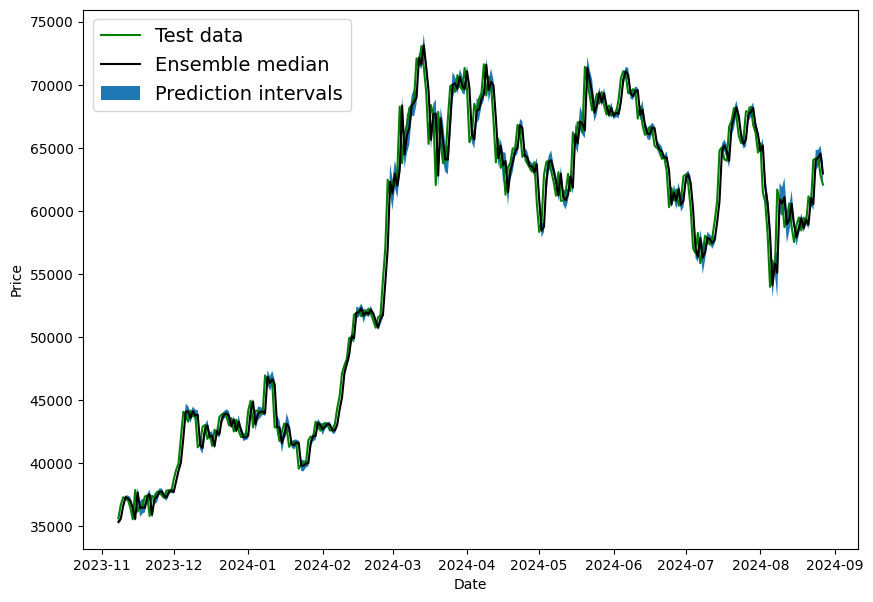

In [132]:
# Get the median of the ensemble predictions
ensemble_median = np.median(ensemble_preds, axis=0)

# Plot the ensemble median predictions with upper and lower bounds
offset = 500
plt.figure(figsize=(10, 7))
plt.plot(X_test.index[offset:], y_test[offset:], "g", label="Test data")
plt.plot(X_test.index[offset:], ensemble_median[offset:], "k-", label="Ensemble median")
plt.xlabel("Date")
plt.ylabel("Price")
plt.fill_between(
    X_test.index[offset:],
    (ensemble_lower)[offset:],
    (ensemble_upper)[offset:],
    label="Prediction intervals",
)
plt.legend(fontsize=14)

So far all of our models predictions have been lagging behind the test data...

As is the're replicating what the naive model does and just predict the previous timestep as the net timestep.

> **🔑Note:** These prediction intervals are estimates themselves. And they have been created with the assumption that our model's data is from a normal distribution.

## Two types of uncertainty (coconut and subway)

Uncertainty estimates in machine learning seek out to qualitatively and quantitatively answer the questions:

1. What can my model know? (with perfect data, what's possible for a model to learn?)

2. What doesn't my model know? (what can a model never predict? Or would it helpful if a model could tell you that when it's making a prediction, it doesn't actually know if it's right or not?)

There are two major types of uncertainty in machine learning you should know about:
* **Aleatoric uncertainty** - this type of uncertainty cannot be reduced and it is often referred as "data" uncertainty or "subway" uncertainty
* **Epistemic uncertainty** - this type of uncertainty can be reduced, it also referred to as "model" or "coconut" uncertainty

## Model 9: Train a model on the full historical data to make predictions into the future

So far all our models have predicted on the test dataset, however, this is only a pseudofuture.

Let's now build a model which is capable of predicting into the future!

In [134]:
bitcoin_prices_windowed.tail()

,Price,block_reward,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,,,
2024-08-23,64053.1,3.125,60372.2,61158.1,59005.8,59470.9,58446.3,59483.1,58877.2
2024-08-24,64159.3,3.125,64053.1,60372.2,61158.1,59005.8,59470.9,58446.3,59483.1
2024-08-25,64273.2,3.125,64159.3,64053.1,60372.2,61158.1,59005.8,59470.9,58446.3
2024-08-26,62846.2,3.125,64273.2,64159.3,64053.1,60372.2,61158.1,59005.8,59470.9
2024-08-27,62084.1,3.125,62846.2,64273.2,64159.3,64053.1,60372.2,61158.1,59005.8


In [148]:
# Train model on full data
full_X = bitcoin_prices_windowed.dropna().drop(["Price", "block_reward"], axis=1).astype(np.float32)
full_y = bitcoin_prices_windowed.dropna()['Price'].astype(np.float32)

full_X.head()

,Price+1,Price+2,Price+3,Price+4,Price+5,Price+6,Price+7
Date,,,,,,,
2013-10-17,152.800003,158.100006,151.399994,147.500000,142.899994,140.100006,140.399994
2013-10-18,157.600006,152.800003,158.100006,151.399994,147.500000,142.899994,140.100006
2013-10-19,168.300003,157.600006,152.800003,158.100006,151.399994,147.500000,142.899994
2013-10-20,183.100006,168.300003,157.600006,152.800003,158.100006,151.399994,147.500000
2013-10-21,186.100006,183.100006,168.300003,157.600006,152.800003,158.100006,151.399994


In [150]:
# Use tf.data API to make full dataset
full_dataset = tf.data.Dataset.from_tensor_slices((full_X, full_y)).batch(1024).prefetch(tf.data.AUTOTUNE)

full_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 7), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [151]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model_9
model_9 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_9')

# Compile model_9
model_9.compile(loss='mae',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['mae', 'mse'])

# Fit model_9
model_9.fit(full_dataset,
            epochs=100,
            verbose=1)

Epoch 1/100


4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - loss: 10952.3916 - mae: 10952.3916 - mse: 443920480.0000
Epoch 2/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 6397.5342 - mae: 6397.5342 - mse: 149079136.0000
Epoch 3/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1707.7397 - mae: 1707.7397 - mse: 10426048.0000
Epoch 4/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 2934.6479 - mae: 2934.6479 - mse: 40308376.0000
Epoch 5/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 3384.6970 - mae: 3384.6970 - mse: 45614204.0000
Epoch 6/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 1562.4016 - mae: 1562.4016 - mse: 9719053.0000
Epoch 7/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 988.2520 - mae: 988.2520 - mse: 5189528.0000
Epoch 8/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 1379.6591 - mae: 1379.6591 - mse: 8176761.0000
Epoch 9/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 526.6985 - mae: 526.6985 - mse: 1430113.7500
Epoch 10/100
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 880.0034 - 

### Make predictions into future

To make predictions into the future we want a function which:

1. Takes as input:
    * A list of values (Bitcoin historical data)
    * A trained model (such as `model_9`)
    * A window into the future to predict (our `INTO_FUTURE` variable)
    * The window size a model was trained on (`WINDOW_SIZE`) - the model can only predict on the same kind of data it was trained on

2. Creates an empty list for future forecasts (this will be returned at the end of the end, when it's full of predictions) and extracts the last `WINDOW_SIZE` values from the input values

3. Loop `INTO_FUTURE` times making a prediction on `WINDOW_SIZE` sequences which update to remove the first value and append the latest prediction.

In [182]:
# How many days in the future we should forecast
INTO_FUTURE = 14

In [183]:
# Create a function to forecast into the future
def forecast_future(values, model, into_future, window_size=WINDOW_SIZE) -> list:
    """
    Make future forecasts into_future steps after values ends.

    Returns future forecasts as a list of floats.
    """
    # Create an empty list to hold future forecasts
    future_forecast = []
    last_window = values[-window_size:] # get the last window of known values

    # Forecast into the future
    for _ in range(into_future):
        # Make a prediction on the last window and get the forecasted value
        forecast = model.predict(tf.expand_dims(last_window, axis=0))
        print(f"Predicting on: \n {last_window} -> Forecast: {tf.squeeze(forecast).numpy()}\n")
        # Append the forecasted value to the future_forecast list
        future_forecast.append(tf.squeeze(forecast).numpy())
        # Update last window with new forecast and drop the first value
        last_window = np.append(last_window, forecast)[-window_size:]

    return future_forecast

In [184]:
# Forecast into the future
future_forecast = forecast_future(values=full_y,
                                  model=model_9,
                                  into_future=INTO_FUTURE,
                                  window_size=WINDOW_SIZE)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicting on: 
 Date
2024-08-21    61158.101562
2024-08-22    60372.199219
2024-08-23    64053.101562
2024-08-24    64159.300781
2024-08-25    64273.199219
2024-08-26    62846.199219
2024-08-27    62084.101562
Name: Price, dtype: float32 -> Forecast: 61154.30859375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicting on: 
 [60372.2  64053.1  64159.3  64273.2  62846.2  62084.1  61154.31] -> Forecast: 61426.80078125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
Predicting on: 
 [64053.1  64159.3  64273.2  62846.2  62084.1  61154.31 61426.8 ] -> Forecast: 63813.1875

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Predicting on: 
 [64159.3   64273.2   62846.2   62084.1   61154.31  61426.8   63813.188] -> Forecast: 63558.43359375

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicting on: 
 [64273.2   62846.2   62084.1   61154.31  61426.8   63813.188 63558.434] -> Forecast: 62796.9453125

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicting on: 
 [62846.2   62084.1   61154.31  614

### Plot future forecasts

In [185]:
future_forecast

[61154.31,
 61426.8,
 63813.188,
 63558.434,
 62796.945,
 61888.773,
 61330.367,
 61312.375,
 61936.855,
 63162.37,
 62610.887,
 61691.508,
 61216.582,
 61059.52]

In [186]:
def get_future_dates(start_date, into_future, offset=1):
    """
    Returns array of datetime values from start_date to start_date + into_future.
    """
    start_date = start_date + np.timedelta64(offset, 'D') # add one day to start date
    end_date = start_date + np.timedelta64(into_future, 'D') # add into_future days to start date
    return np.arange(start_date, end_date, dtype='datetime64[D]') # return range of dates from start to end date

In [187]:
# Last date in the Bitcoin historical data
last_date = bitcoin_prices.index[-1]
last_date

Timestamp('2024-08-27 00:00:00')

In [188]:
# Get future dates
future_dates = get_future_dates(start_date=last_date, into_future=INTO_FUTURE)
future_dates

array(['2024-08-28', '2024-08-29', '2024-08-30', '2024-08-31',
       '2024-09-01', '2024-09-02', '2024-09-03', '2024-09-04',
       '2024-09-05', '2024-09-06', '2024-09-07', '2024-09-08',
       '2024-09-09', '2024-09-10'], dtype='datetime64[D]')

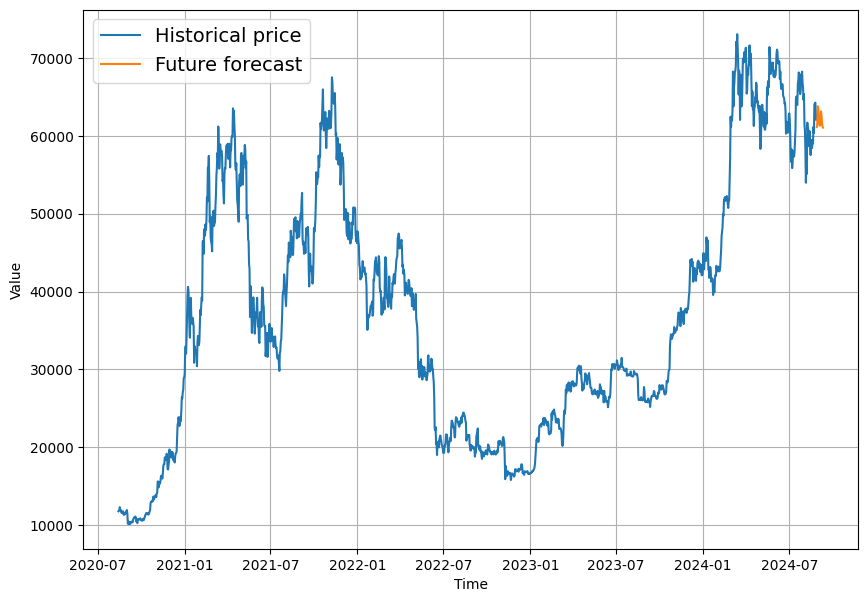

In [189]:
# Plot the future forecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=bitcoin_prices.index, values=bitcoin_prices['Price'], start=2500, format="-", label="Historical price")
plot_time_series(timesteps=future_dates, values=future_forecast, start=None, format="-", label="Future forecast")

## Model 10: Why forecasting in BS (the turkey problem 🦃)

In [193]:
# Let's introduce a turkey problem to our Bitcoin data
# Turkey problem: an unexpected event which causes a model to make poor predictions
# In this case, we'll introduce a sudden drop in Bitcoin price
btc_price_turkey = prices.copy()
btc_price_turkey[-1] = btc_price_turkey[-1] / 100 # reduce the last price by half
btc_price_turkey[-10:]

array([58446.3  , 59470.9  , 59005.8  , 61158.1  , 60372.2  , 64053.1  ,
       64159.3  , 64273.2  , 62846.2  ,   620.841])

In [194]:
# Get the time steps for the turkey problem
btc_timesteps_turkey = np.array(bitcoin_prices.index)
btc_timesteps_turkey[-10:]

array(['2024-08-18T00:00:00.000000000', '2024-08-19T00:00:00.000000000',
       '2024-08-20T00:00:00.000000000', '2024-08-21T00:00:00.000000000',
       '2024-08-22T00:00:00.000000000', '2024-08-23T00:00:00.000000000',
       '2024-08-24T00:00:00.000000000', '2024-08-25T00:00:00.000000000',
       '2024-08-26T00:00:00.000000000', '2024-08-27T00:00:00.000000000'],
      dtype='datetime64[ns]')

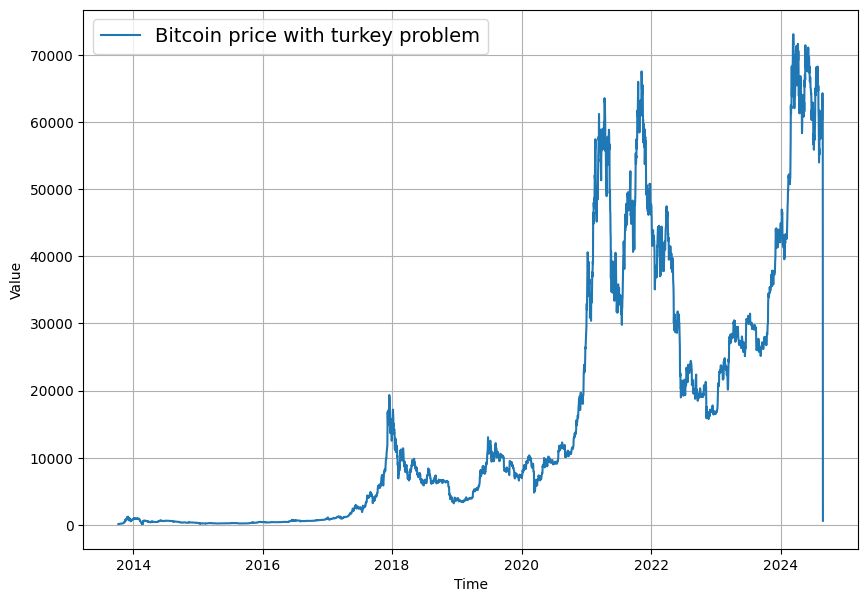

In [195]:
plt.figure(figsize=(10, 7))
plot_time_series(
    timesteps=btc_timesteps_turkey,
    values=btc_price_turkey,
    format="-",
    label="Bitcoin price with turkey problem",
)

In [196]:
# Create train/test splits
full_windows, full_labels = make_windows(btc_price_turkey, window_size=WINDOW_SIZE, horizon=HORIZON)

# Make train/test splits
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)

### Build a turkey model (model to predict on turkey data)

In [197]:
# Set random seed for as reproducible results as possible
tf.random.set_seed(42)

# Construct model_10
model_10 = tf.keras.Sequential([
    layers.Dense(128, activation='relu'),
    layers.Dense(HORIZON)
], name='model_10')

# Compile model_10
model_10.compile(loss='mae',
                 optimizer=tf.keras.optimizers.Adam(),
                 metrics=['mae', 'mse'])

# Fit model_10
model_10.fit(train_windows,
             train_labels,
             epochs=100,
             verbose=1,
             validation_data=(test_windows, test_labels),
             callbacks=[create_model_checkpoint(model_name=model_10.name)])

Epoch 1/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 3710.8059 - mae: 3710.8059 - mse: 92059864.0000 - val_loss: 1313.3350 - val_mae: 1313.3350 - val_mse: 8339680.0000
Epoch 2/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 633.0626 - mae: 633.0626 - mse: 1936271.8750 - val_loss: 1292.0349 - val_mae: 1292.0349 - val_mse: 8184265.0000
Epoch 3/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 564.7886 - mae: 564.7886 - mse: 1533530.7500 - val_loss: 1232.7947 - val_mae: 1232.7947 - val_mse: 7909296.0000
Epoch 4/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 516.3762 - mae: 516.3762 - mse: 1288325.6250 - val_loss: 1269.5238 - val_mae: 1269.5238 - val_mse: 8064643.0000
Epoch 5/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 515.8183 - mae: 515.8183 - mse: 1286247.0000 - val_loss: 1037.6670 - val_mae: 1037.6670 - val_mse: 7158321.0000
Epoch 6/100
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 485.4974 - mae: 485.4974 - mse: 1154334.8750 - val_loss: 952.4976 - va

In [198]:
# Load in best version of model 10 and evaluate on test data
model_10 = tf.keras.models.load_model('model_experiments/model_10.keras')
model_10.evaluate(test_windows, test_labels)

25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - loss: 478.4995 - mae: 478.4995 - mse: 945682.1250


[749.7991333007812, 749.7991333007812, 6110165.5]

In [199]:
# Make predictions using model_10 on the test dataset and view the results
model_10_preds = make_preds(model_10, test_windows)

# Evaluate preds
model_10_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_10_preds)
model_10_results

25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


{'mae': 749.79913,
 'mse': 6110165.5,
 'rmse': 2471.875,
 'mape': 14.439432322978973,
 'mase': 0.993219}

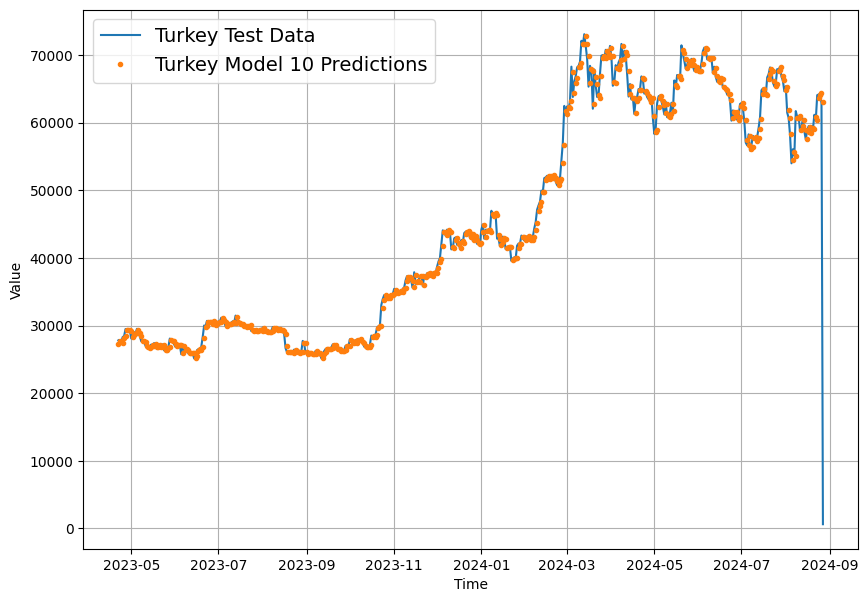

In [202]:
plt.figure(figsize=(10, 7))
offset = 300
plot_time_series(
    timesteps=btc_timesteps_turkey[-len(test_windows) :],
    values=btc_price_turkey[-len(test_labels) :],
    start=offset,
    format="-",
    label="Turkey Test Data",
)
plot_time_series(
    timesteps=btc_timesteps_turkey[-len(test_windows) :],
    values=model_10_preds,
    start=offset,
    label="Turkey Model 10 Predictions",
)